# prompting the past
Distant reading code for the [Prompting the Past DH 2024 proposal](https://github.com/inactinique/DH2024_prompting_the_past/).
This code has been written with the help of ChatGPT and ollama (codellama)

This is a work in progress.

## We start with LDA (gensim)

### required libraries

- gensim (gensim-4.3.2 numpy-1.26.2 scipy-1.11.4 smart-open-6.4.0)
- pandas (pandas-2.1.3 pytz-2023.3.post1 tzdata-2023.3)
- nltk (click-8.1.7 nltk-3.8.1 regex-2023.10.3 tqdm-4.66.1)
- pyLDAvis (MarkupSafe-2.1.3 funcy-2.0 jinja2-3.1.2 joblib-1.3.2 numexpr-2.8.7 pyLDAvis-3.4.1 scikit-learn-1.3.2 setuptools-69.0.2 threadpoolctl-3.2.0)
- matplotlib (contourpy-1.2.0 cycler-0.12.1 fonttools-4.46.0 kiwisolver-1.4.5 matplotlib-3.8.2 pyparsing-3.1.1)
- networkx-3.2.1
- plotly (plotly-5.18.0 tenacity-8.2.3)
-  fastjsonschema-2.19.0 jsonschema-4.20.0 jsonschema-specifications-2023.11.2 nbformat-5.9.2 referencing-0.31.1 rpds-py-0.13.2

In [1]:
# Install necessary libraries if you haven't already
# !pip install gensim
# !pip install numpy
# !pip install nltk 
# !pip install pyLDAvis
# !pip install matplotlib
# !pip install networkx
# !pip install plotly
# !pip install nbformat

# beware: scikit version must be max 1.12.0

### import libraries

In [2]:
# Import libraries
from gensim import corpora
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from pprint import pprint
import nltk
from nltk.corpus import stopwords
import csv


### load the corpus

In [3]:
# define corpus_file

# remove # below to work with the european union file
# corpus_file = 'data/european_union.txt'
# Read the corpus from the file
# with open(corpus_file, 'r', encoding='utf-8') as file:
#    corpus = [line.strip() for line in file]

# fun with the krea corpus
# the krea has 10 778 778 rows
corpus_file = 'data/prompts.csv'
corpus_prefilter = []

# Read the csv file
with open(corpus_file, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader) # This will store the first row (header) in a variable
    for row in reader:
        corpus_prefilter.append(row[0]) # only append the first column of each row

### filter the corpus

In [12]:
# Filter the corpus. Uncomment if interesting. We filter here on those words: 'european', 'europe', 'EU'
# query_list = ['european union', 'european parliament', 'european commission', 'european council']
# corpus = [row for row in corpus_prefilter if any(query in row for query in query_list)]
# print(corpus)

# We're goin to filter it to get all rows with a word starting with 'histor'

import re

corpus = [text for text in corpus_prefilter if re.search(r'\bhistor', text.lower()) or 'past' in text.lower()]

In [13]:
import pandas as pd
corpus_df = pd.DataFrame(corpus, columns=['text'])
print(type(corpus_df))
print(corpus_df.head())
print(corpus_df.count())


<class 'pandas.core.frame.DataFrame'>
                                                text
0  epic portrait mona lisa eating an apple, beaut...
1  high quality high detail painting by norman ro...
2  Concept art Portrait of the ancient historical...
3  telephoto 7 0 mm f / 2. 8 iso 2 0 0 photograph...
4  the existential dread you feel as all of the w...
text    140453
dtype: int64


### write the filtered corpus, for instance for use in iramuteq

In [14]:
with open("filtered_corpus_histor.txt", "w", encoding='utf-8') as file:
    file.writelines(f"{item}\n" for item in corpus)

### prepare the corpus: remove stopwords, tokenize, create a dictionnary, filter out few used words

In [15]:
# we disable ssl checking, otherwise nltk.download won't work. Other solutions are available here: https://stackoverflow.com/questions/41348621/ssl-error-downloading-nltk-data
# uncomment if necessary (if nltk_data is not downloaded)

# import ssl
#try:
#    _create_unverified_https_context = ssl._create_unverified_context
#except AttributeError:
#    pass
#else:
#    ssl._create_default_https_context = _create_unverified_https_context

# nltk stopwords

# uncomment line below if you need to download nltk_data
# nltk.download()
stop_words = set(stopwords.words('english'))

# Tokenize the texts and remove stopwords
tokenized_texts = [[word for word in text.split() if word.lower() not in stop_words] for text in corpus]

# Create a dictionary representation of the documents
dictionary = Dictionary(tokenized_texts)

# Filter out words that occur less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)




### And now LDA


In [16]:
# Create a bag-of-words representation of the documents
corpus_bow = [dictionary.doc2bow(text) for text in tokenized_texts]

# Train the LDA model
num_topics = 25  # You can adjust this parameter based on your requirements
lda_model = LdaModel(corpus_bow, num_topics=num_topics, id2word=dictionary, passes=15)

# Print the topics and their top words
pprint(lda_model.print_topics())

[(0,
  '0.013*"full" + 0.011*"3" + 0.011*"render" + 0.008*"-" + 0.008*"4" + '
  '0.008*"trending" + 0.007*"details," + 0.007*"bright" + 0.007*"portrait," + '
  '0.007*"octane"'),
 (1,
  '0.029*"art" + 0.023*"8" + 0.018*"wearing" + 0.015*"black" + 0.013*"extreme" '
  '+ 0.013*"volumetric" + 0.013*"photograph" + 0.012*"high" + 0.012*"film" + '
  '0.011*"wide"'),
 (2,
  '0.035*"david" + 0.035*"8" + 0.035*"colours," + 0.035*"canvas," + 0.033*"k" '
  '+ 0.032*"|" + 0.031*"pastell" + 0.031*"cell" + 0.030*"shusei" + '
  '0.030*"airbrush"'),
 (3,
  '0.022*"matte" + 0.020*"colors," + 0.020*"huge" + 0.015*"covered" + '
  '0.014*"dark" + 0.014*"intricate" + 0.014*"beautiful" + 0.013*"painting," + '
  '0.013*"flowers," + 0.012*"cinematic"'),
 (4,
  '0.034*"painting" + 0.030*"oil" + 0.029*"impasto" + 0.027*"trending" + '
  '0.014*"portrait" + 0.014*"," + 0.013*"paint" + 0.012*"thick" + '
  '0.012*"artstation" + 0.011*"style"'),
 (5,
  '0.035*"(" + 0.031*"0" + 0.025*")" + 0.024*"art" + 0.018*"1" + 0

### Visualize topics

In [17]:
# Import library
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Visualize topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.display(vis)


### looking at dominant topic for each document (line in the corpus)

In [18]:
# Get the dominant topic for each document in the corpus
dominant_topics = [max(lda_model[doc], key=lambda x: x[1]) for doc in corpus_bow]

# Create a dictionary to store texts for each topic
topics_dict = {i: [] for i in range(num_topics)}

# Group texts by their dominant topics
for i, topic in enumerate(dominant_topics):
    topics_dict[topic[0]].append(corpus[i])

# Print texts for each topic
for topic, texts in topics_dict.items():
    print(f"Topic {topic}:")
    for text in texts:
        print(f" - {text}")
    print("\n")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# number of documents per topics

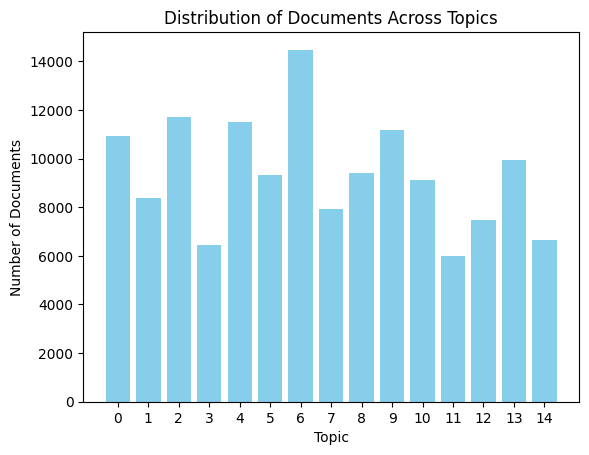

In [19]:

import matplotlib.pyplot as plt
import numpy as np

# Count the number of documents in each topic
topic_counts = np.zeros(num_topics)
for topic in dominant_topics:
    topic_counts[topic[0]] += 1

# Plot the bar chart
plt.bar(range(num_topics), topic_counts, tick_label=range(num_topics), color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Distribution of Documents Across Topics')
plt.show()


## word2vec

In [ ]:

# Import libraries
from gensim.models import Word2Vec
import re

# Read the corpus from the file
with open(corpus_file, 'r', encoding='utf-8') as file:
    corpus = [line.strip() for line in file]

# Import NLTK stopwords
stop_words = set(stopwords.words('english'))

# Tokenize and clean the texts
def preprocess_text(text):
    # Convert to lowercase and remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    return tokens

# Tokenize and clean the entire corpus
tokenized_corpus = [preprocess_text(text) for text in corpus]

# Train the Word2Vec model
model_w2v = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=5, workers=4)

# Save the model for future use
model_w2v.save('word2vec_model.model')

# Example usage: find similar words to a given word
similar_words = model_w2v.wv.most_similar('napoleon', topn=5)
print("Similar words to 'napoleon':", similar_words)


In [ ]:
# Example usage: find similar words to a given word
similar_words = model_w2v.wv.most_similar('history', topn=500)
print("Similar words to 'history':", similar_words)

### Let's visualize some word vectors

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import networkx as nx

# Get the 150 most used words in the corpus
most_used_words = model_w2v.wv.index_to_key[:150]

# Create a graph
G = nx.Graph()

# Add nodes for the most used words
G.add_nodes_from(most_used_words)

# Add edges between each word and its similar words
for word in most_used_words:
    similar_words = model_w2v.wv.most_similar(word, topn=5)
    for similar_word, _ in similar_words:
        G.add_edge(word, similar_word)

# Plot the graph
pos = nx.spring_layout(G, seed=42)  # Set seed for reproducibility
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, font_size=8, node_size=2000, font_color='black', node_color='skyblue', edge_color='gray', linewidths=0.5)
plt.title('Graph of Similar Words to the 30 Most Used Words')
plt.show()


### another version

In [ ]:
# Install necessary libraries if you haven't already
# !pip install networkx matplotlib

# Import libraries
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Get the 3000 most used words in the corpus
most_used_words = model_w2v.wv.index_to_key[:3000]

# Create nodes and calculate node sizes based on word frequency
scaling_factor = 200  # Adjust this factor based on your preference
word_counts = Counter(token for line in tokenized_corpus for token in line)

nodes = {word: {'group': 1, 'freq': word_counts[word] / len(tokenized_corpus) * 1000} for word in most_used_words}

# Create edges
edges = [(word, similar_word) for word in most_used_words for similar_word, _ in model_w2v.wv.most_similar(word, topn=5)]

# Create the network graph
G = nx.Graph()

# Add nodes with clustering and sizes
for node, data in nodes.items():
    G.add_node(node, **data)

# Add edges
G.add_edges_from(edges)

# Print node data to inspect the structure
print("Node Data Structure:")
for node, data in G.nodes(data=True):
    print(node, data)

# Calculate clustering coefficients for each node
clustering = nx.clustering(G)

# Set node colors based on clustering coefficient
node_colors = [clustering[node] for node in G.nodes]

# Set node sizes based on relative word frequency with linear scaling
min_size = 1000  # Minimum node size
max_size = 10000  # Maximum node size

# Extract frequencies directly from the nodes dictionary, handling missing 'freq' attribute
frequencies = [data.get('freq', 0) for _, data in G.nodes(data=True)]

# Ensure that there are frequencies and calculate the max frequency
max_freq = max(frequencies) if frequencies else 1

# Set node sizes based on relative word frequency with linear scaling
node_sizes = [min_size + (max_size - min_size) * (freq / max_freq) for freq in frequencies]

# Draw the network graph with a larger output image
fig, ax = plt.subplots(figsize=(150, 100))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, font_size=8, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Blues, font_color='black', edge_color='gray', linewidths=0.5)

# Show the plot
plt.title('Network Graph with Clustering and Scaled Node Sizes based on Word Frequency')
plt.show()
